In [3]:
# Thierry Nkombo, 110008016
# Tweet Sentiment Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [7]:
# Load Datasets
train_data = pd.read_csv('C:/Users/thien/COMP 3250/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('C:/Users/thien/COMP 3250/Corona_NLP_test.csv', encoding='latin-1')

# Copy Dataset For Visualization Purposes
train_data_c = train_data.copy()
test_data_c = test_data.copy()

print("--------Training Set----------")
display(train_data.head())

print("\n--------Testing Set----------")
display(test_data.head())


--------Training Set----------


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative



--------Testing Set----------


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


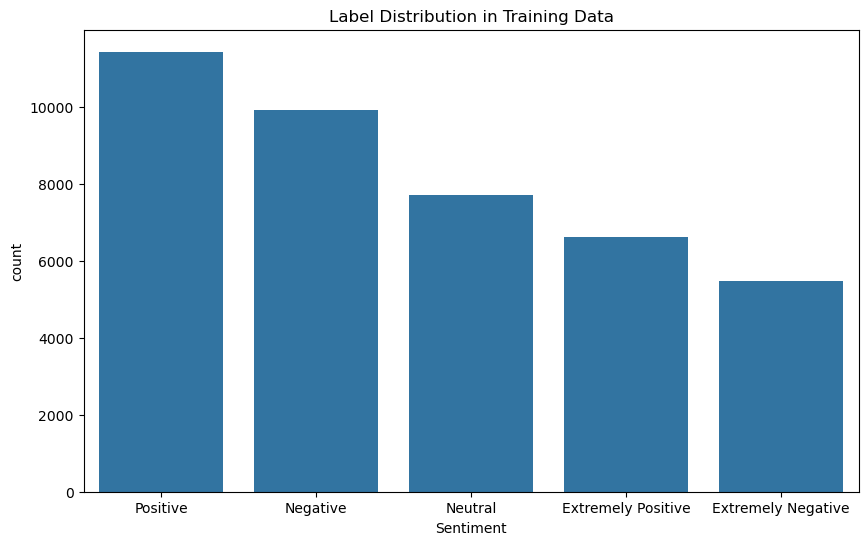

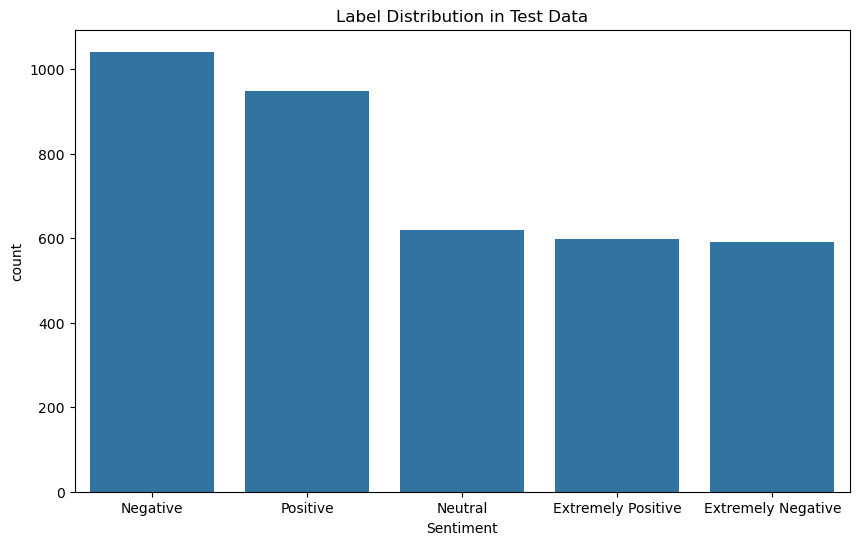

In [9]:
# Distribution of Labels In Train Set
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='Sentiment', order=train_data_c['Sentiment'].value_counts().index)
plt.title('Label Distribution in Training Data')
plt.show()

# Distribution of Labels In Test Set
plt.figure(figsize=(10, 6))
sns.countplot(data=test_data, x='Sentiment', order=test_data_c['Sentiment'].value_counts().index)
plt.title('Label Distribution in Test Data')
plt.show()

In [11]:
# Drop Location; Not A Pertinent Element in This Partiuclar Sentiment Analysis
train_data.drop(columns=['Location'], inplace=True, errors='ignore')
test_data.drop(columns=['Location'], inplace=True, errors='ignore')

In [13]:
print("\n Missing Data in Training Set After Dropping Location:")
print(train_data.isnull().sum())

print("\n Missing Data in Test Set After Dropping Location:")
print(test_data.isnull().sum())
print("\n")


 Missing Data in Training Set After Dropping Location:
UserName         0
ScreenName       0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64

 Missing Data in Test Set After Dropping Location:
UserName         0
ScreenName       0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64




In [15]:
# Preprocess the text
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove Links and URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove Punctuation, Characters, and numbers
    text = text.strip()  # Remove leading/trailing spaces
    return text

# Apply The Text Processing
train_data['Processed_Text'] = train_data['OriginalTweet'].apply(preprocess_text)
test_data['Processed_Text'] = test_data['OriginalTweet'].apply(preprocess_text)

# Convert Sentiment labels to numerical values 0 to 1
sentiment_mapping = {'Extremely Negative': 0, 'Negative': 0, 'Neutral': 1, 'Positive': 2, 'Extremely Positive': 2}
train_data['Sentiment'] = train_data['Sentiment'].map(sentiment_mapping)
test_data['Sentiment'] = test_data['Sentiment'].map(sentiment_mapping)

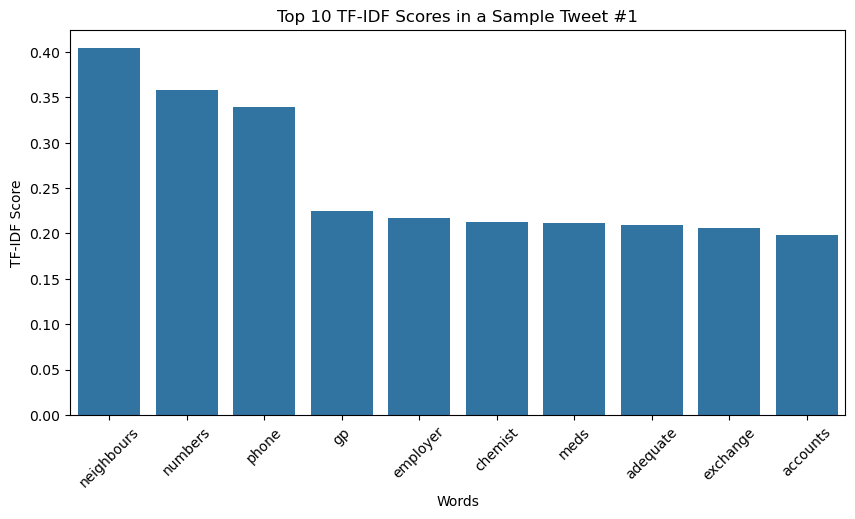

In [17]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train = vectorizer.fit_transform(train_data['Processed_Text'])
X_test = vectorizer.transform(test_data['Processed_Text'])
y_train = train_data['Sentiment']
y_test = test_data['Sentiment']

# Visual Representation of TF-IDF scores for a sample tweet
feature_names = vectorizer.get_feature_names_out()
sample_index = 1
sample_vector = X_train[sample_index].toarray().flatten()
sorted_indices = np.argsort(sample_vector)[::-1][:10]

plt.figure(figsize=(10, 5))
sns.barplot(x=[feature_names[i] for i in sorted_indices], y=[sample_vector[i] for i in sorted_indices])
plt.xlabel("Words")
plt.ylabel("TF-IDF Score")
plt.title("Top 10 TF-IDF Scores in a Sample Tweet #1")
plt.xticks(rotation=45)
plt.show()

In [17]:
# Naive Bayes Classifier
nb_classifier = MultinomialNB(alpha=4)
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)

# Evaluate NB Classifier
print("Naïve Bayes Classifier:")
print(classification_report(y_test, y_pred_nb))

Naïve Bayes Classifier:
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      1633
           1       0.79      0.05      0.09       619
           2       0.60      0.87      0.71      1546

    accuracy                           0.66      3798
   macro avg       0.71      0.53      0.50      3798
weighted avg       0.69      0.66      0.61      3798



In [19]:
# Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

print("Random Forest Classifier:")
print(classification_report(y_test, y_pred_rf))

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1633
           1       0.54      0.59      0.56       619
           2       0.72      0.71      0.72      1546

    accuracy                           0.68      3798
   macro avg       0.66      0.67      0.66      3798
weighted avg       0.69      0.68      0.69      3798



In [19]:
# Support Vector Machine
svm_classifier = SVC(kernel='linear', C=1.0)
svm_classifier.fit(X_train, y_train)
y_pred_svm = svm_classifier.predict(X_test)

print("SVM Classifier:")
print(classification_report(y_test, y_pred_svm))

SVM Classifier:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1633
           1       0.65      0.66      0.66       619
           2       0.81      0.83      0.82      1546

    accuracy                           0.78      3798
   macro avg       0.75      0.76      0.75      3798
weighted avg       0.78      0.78      0.78      3798



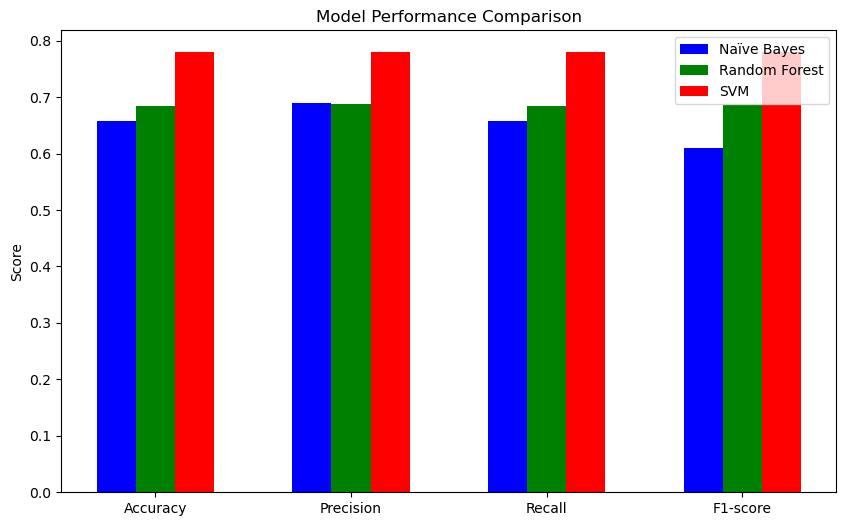

In [27]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

# Evaluate models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
nb_scores = [
    accuracy_score(y_test, y_pred_nb),
    precision_score(y_test, y_pred_nb, average='weighted'),
    recall_score(y_test, y_pred_nb, average='weighted'),
    f1_score(y_test, y_pred_nb, average='weighted')
]
rf_scores = [
    accuracy_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_rf, average='weighted'),
    recall_score(y_test, y_pred_rf, average='weighted'),
    f1_score(y_test, y_pred_rf, average='weighted')
]
svm_scores = [
    accuracy_score(y_test, y_pred_svm),
    precision_score(y_test, y_pred_svm, average='weighted'),
    recall_score(y_test, y_pred_svm, average='weighted'),
    f1_score(y_test, y_pred_svm, average='weighted')
]

# Visualize model performance
x = np.arange(len(metrics))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, nb_scores, width, label='Naïve Bayes', color='blue')
plt.bar(x, rf_scores, width, label='Random Forest', color='green')
plt.bar(x + width, svm_scores, width, label='SVM', color='red')
plt.xticks(x, metrics)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.show()